In [ ]:
DAILY_DATA_PATH = "../data/interim/daily_data.csv"

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# K-Means Clustering

In [3]:
df = pd.read_csv(DAILY_DATA_PATH)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
0,2017-01-01,993.296224,-3.362448,270.319580,-7.272098,74.953357,4.881888,3.554685,1.327413,2.229371,...,0.886014,1.605804,178.867413,0.000000,0.000000,58.551119,90.925105,94.176014,10.099021,443.863636
1,2017-01-02,991.612222,-0.730417,273.087222,-2.933750,85.047222,5.806528,4.941736,0.864028,3.105556,...,1.878056,3.373056,209.636111,0.002083,121.944444,19.536597,37.859306,46.845278,10.440556,428.882639
2,2017-01-03,992.582639,1.384097,275.130069,-1.990069,78.212500,6.762847,5.280556,1.482847,3.316111,...,2.392569,4.875903,232.829861,0.000000,15.555556,22.890139,48.076181,54.296806,11.752083,415.114583
3,2017-01-04,981.120556,2.290972,276.956597,-1.145486,78.137639,7.220208,5.630556,1.590069,3.577639,...,3.666111,7.208125,250.679167,0.010417,27.986111,27.245417,53.143681,80.150625,11.856389,411.563889
4,2017-01-05,998.896181,-3.516111,269.735625,-6.855486,77.937222,4.745208,3.679722,1.065903,2.295625,...,2.322014,4.481528,147.092292,0.007639,179.652778,24.196597,49.501250,58.527708,8.594653,413.460417


In [4]:
df['Date Time'] = pd.to_datetime(df['Date Time'])

In [5]:
feature_cols = [col for col in df.columns if col not in ['Date Time', 'CO2 (ppm)']]
X = df[feature_cols]

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
inertia = []
k_range = range(1, 20)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

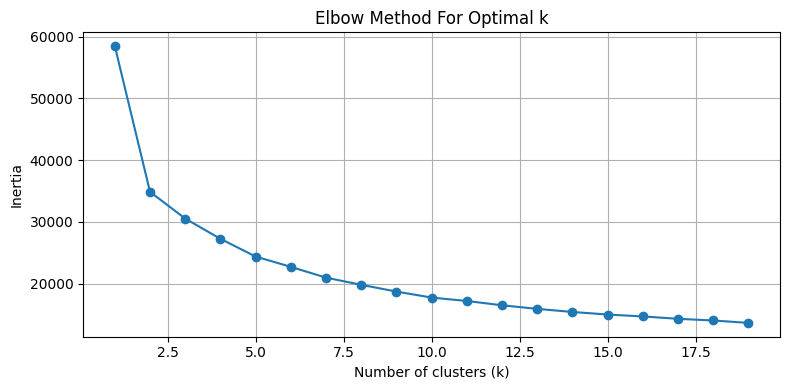

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show();

In [9]:
kmeans_final = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans_final.fit_predict(X_scaled)

In [10]:
cluster_summary = df.groupby('Cluster')['CO2 (ppm)'].agg(['count', 'mean']).sort_values(by='mean', ascending=False)
cluster_summary

,count,mean
Cluster,,
0,1624,430.386547
1,1299,426.094893


In [11]:
centroids_scaled = kmeans_final.cluster_centers_
centroids_unscaled = pd.DataFrame(
    scaler.inverse_transform(centroids_scaled),
    columns=feature_cols
)

centroids_unscaled['CO2_mean'] = cluster_summary['mean'].values
centroids_unscaled['Cluster'] = cluster_summary.index

In [12]:
centroids_sorted = centroids_unscaled.sort_values(by='CO2_mean', ascending=False).reset_index(drop=True)
centroids_sorted

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2_mean,Cluster
0,989.792242,5.121523,279.10211,1.820833,80.898134,9.284585,7.307679,1.976866,4.609771,7.388369,...,3.829823,180.132743,0.008034,41.052372,69.645355,134.174210,164.444169,15.465795,430.386547,0
1,989.562221,17.659617,291.69060,11.073046,68.576981,21.271651,13.593663,7.677900,8.594559,13.741230,...,3.282248,171.989860,0.010979,19.125984,203.491148,399.299627,485.226906,28.402621,426.094893,1


In [13]:
# centroids_sorted.to_csv("centroids_sorted.csv", index=False)

# Hierarchical

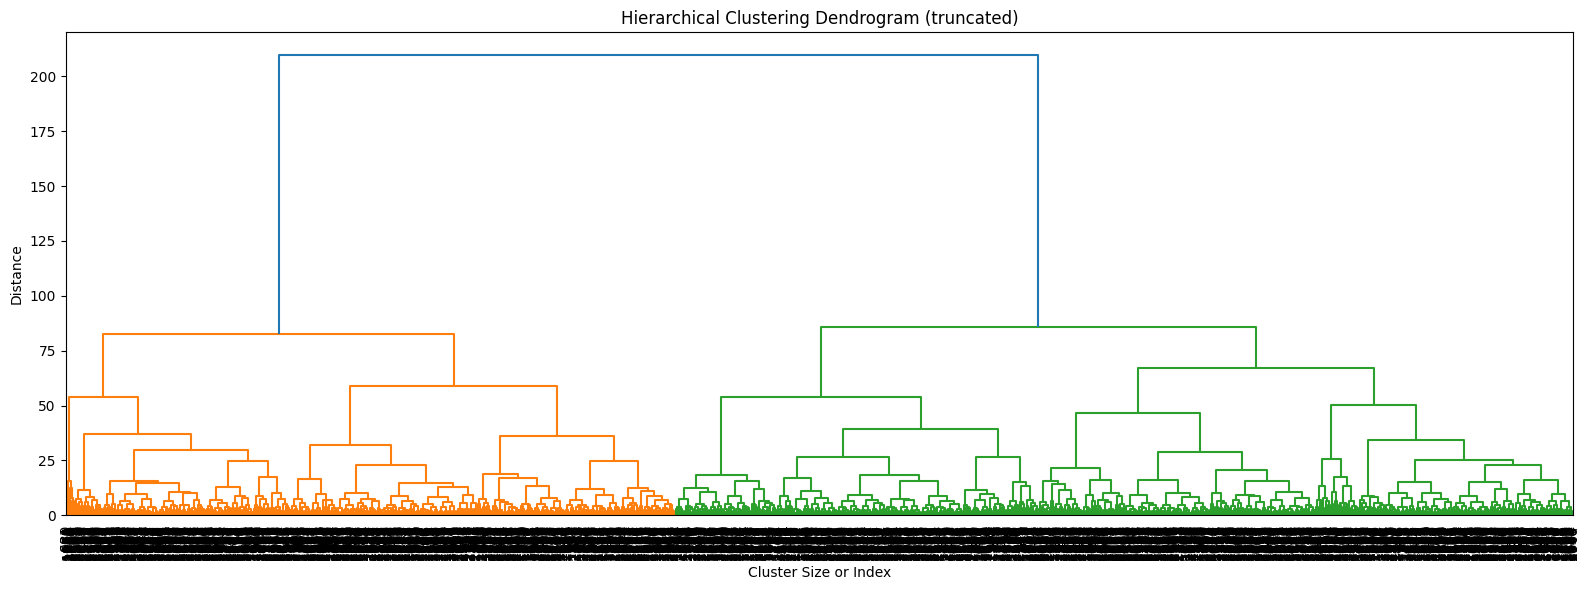

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Step 2: Load your dataset
df = pd.read_csv(DAILY_DATA_PATH)
df['Date Time'] = pd.to_datetime(df['Date Time'])

# Step 3: Select and standardize features
feature_cols = [col for col in df.columns if col not in ['Date Time', 'CO2 (ppm)']]
X = df[feature_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Compute the linkage matrix for hierarchical clustering
Z = linkage(X_scaled, method='ward')  # 'ward' minimizes within-cluster variance

# Step 5: Plot the dendrogram
plt.figure(figsize=(16, 6))
dendrogram(
    Z,
    # truncate_mode='lastp',   # show only the last p merged clusters
    # p=30,                    # number of clusters to display in dendrogram
    leaf_rotation=90.,
    leaf_font_size=10.,
    # show_contracted=True     # to get a compact view
)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Cluster Size or Index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show();

In [32]:
from sklearn.cluster import AgglomerativeClustering

agg_model = AgglomerativeClustering(n_clusters=2)
df['Agg_Cluster'] = agg_model.fit_predict(X_scaled)

# Analyze CO2 levels per cluster
agg_cluster_summary = df.groupby('Agg_Cluster')['CO2 (ppm)'].agg(['count', 'mean']).sort_values(by='mean', ascending=False)

# Compute feature means per cluster for interpretation
feature_means = df.groupby('Agg_Cluster')[feature_cols].mean()
feature_means['CO2_mean'] = agg_cluster_summary['mean']

feature_means

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2_mean
Agg_Cluster,,,,,,,,,,,,,,,,,,,,,
0,989.487566,5.813133,279.820973,2.375946,80.297596,9.85043,7.640130,2.210252,4.821950,7.727096,...,2.334648,3.860556,181.400126,0.006620,37.405800,74.489469,143.953793,178.607784,16.144669,430.017220
1,989.988219,17.882006,291.877837,11.171233,68.241922,21.62474,13.726203,7.898454,8.676469,13.871147,...,1.869825,3.182779,169.317075,0.013354,22.326741,209.604816,411.138392,496.117538,28.683238,426.214077


In [33]:
# feature_means.to_csv("feature_means.csv", index=False)